<center style><h3>Computer Assignment 5 - phase 1</h3></center>
<center style><h4>Neural Network - Feed Forward</h4></center>
 <h4 style="text-align:right">
        محمد پویا افشاری - 810198577
</h4>


# Part 1


## MLP from scratch


In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:

- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2


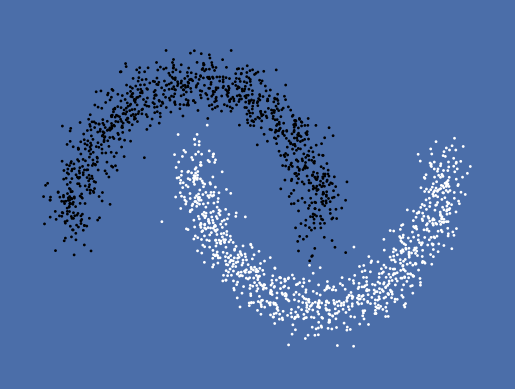

In [1]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset


def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')


X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()


In [129]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier


def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting

    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)

    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z > 0.5, cmap='Blues')

    # then plot the dataset
    plot_data(ax, X, Y)


## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](<https://en.wikipedia.org/wiki/Rectifier_(neural_networks)>) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).


In [130]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        return grad_output * (np.array(self.x) > 0)

    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        pass


class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.x = x
        return 1 / (1 + np.exp(-x))

    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        sigmoid = self.forward(self.x)
        return grad_output * sigmoid * (1 - sigmoid)

    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        pass


Probably a good time to test your functions...


In [131]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])


array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [132]:
test_relu.backward(np.ones(1))


array([0., 0., 1., 0., 1., 1.])

In [133]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))


array([0.73105858])

In [134]:
test_sig.backward(np.ones(1))


array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.


In [135]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        self.x = x.copy()
        # return Wx + b
        return np.dot(x, self.W) + self.b

    def backward(self, grad_output):
        # Reshape grad_output to be a column vector
        grad_output = grad_output.reshape(-1, 1)
        self.x = self.x.reshape(1, -1)  # Reshape self.x to be a row vector

        dW = np.dot(self.x.T, grad_output)
        db = np.sum(grad_output, axis=0)
        dx = np.dot(grad_output, self.W.T)
        return dx, dW, db

    def step(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.


In [136]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        self.layers = []

    def add_layer(self, layer):
        # Add a layer to the model
        self.layers.append(layer)

    def forward(self, x):
        # Forward pass through the layers
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def compute_loss(self, out, label):
        # Compute Binary Cross Entropy (BCE) loss
        loss = -(label * np.log(out + 1e-10) +
                 (1 - label) * np.log(1 - out + 1e-10))
        gradient = -((label / (out + 1e-10)) -
                     ((1 - label) / (1 - out + 1e-10)))
        return loss, gradient

    def backward(self, gradient):
        # Backward pass through the layers
        for layer in reversed(self.layers):
            if isinstance(layer, MyLinear):
                gradient, dW, db = layer.backward(gradient)
                layer.dW = dW
                layer.db = db
            else:
                gradient = layer.backward(gradient)

    def step(self, learning_rate):
        # Update the parameters of each layer
        for layer in self.layers:
            if isinstance(layer, MyLinear):
                layer.step(learning_rate)


In [137]:
n_input = X.shape[1]
hidden_size = 50
output_size = 1


network = Sequential()

# Add layers to the network
network.add_layer(MyLinear(n_input, hidden_size))
network.add_layer(MyReLU())
network.add_layer(MyLinear(hidden_size, output_size))
network.add_layer(MySigmoid())


In [138]:
losses = []
learning_rate = 1e-2
epochs = 10

for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        idx = np.random.randint(len(X))

        # select the corresponding example and label
        example = X[idx]
        label = Y[idx]

        # do a forward pass on the example
        output = network.forward(example)

        # compute the loss according to your output and the label
        loss = network.compute_loss(output, label)
        losses.append(loss)

        # backward pass
        gradient = 1.0
        network.backward(gradient)

        # gradient step
        network.step(learning_rate)


ValueError: shapes (2,1) and (50,1) not aligned: 1 (dim 1) != 50 (dim 0)

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 2, 1)

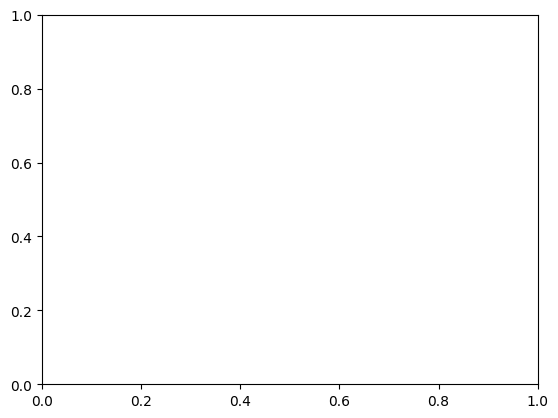

In [ ]:
%matplotlib inline
plt.plot(losses)
plt.show()


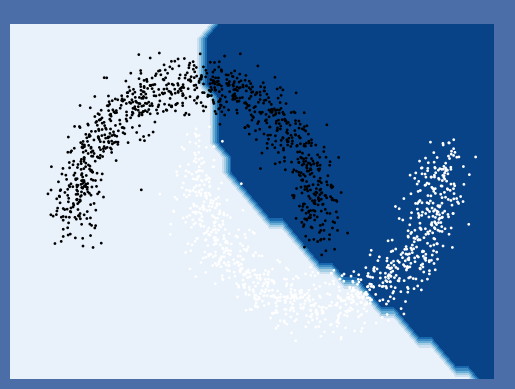

In [139]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()


# Part 2 : Preprocess


TF_IDF: stands for Term Frequency-Inverse Document Frequency. It is a numerical statistic used to evaluate the importance of a term in a document within a collection of documents or a corpus. TF-IDF is commonly used in information retrieval and text mining. TF (Term Frequency) calculates the frequency of a term (word) within a document. IDF (Inverse Document Frequency) measures the importance of a term in the entire corpus, is calculated by taking the logarithm of the ratio between the total number of documents in the corpus and the number of documents containing the term. The TF-IDF score is calculated by multiplying the TF and IDF scores for a term in a document. The purpose of TF-IDF is to give more weight to terms that are frequent in a document but rare in the corpus, as they are more likely to carry important meaning or information.


Stemming vs. Lemmatization:

> Stemming is a process of removing affixes from words to obtain their base or root form, known as the stem examle\_> running == run or jumped == jump

Stemming can be useful when the exact meaning of the word is not critical, and you want to reduce words to a common base form for tasks like information retrieval or word frequency analysis

> Lemmatization, on the other hand, aims to determine the base form of a word, known as the lemma, by considering its context and part of speech. Historical == Histori

Lemmatization takes into account the morphological analysis of words and considers the context in which the word appears. It ensures that the resulting lemma is a valid word and preserves the intended meaning of the original word. Lemmatization is often preferred over stemming in tasks that require a more accurate analysis, such as natural language understanding, language translation, and sentiment analysis.


Check that the value of each feature is between 0 and 1 before giving input to the neural network. What problems can occur if this condition is not met?

By using `MinMaxScaler` in my code I transformed values of each feature between 0 and 1.

If the condition of having feature values between 0 and 1 is not met, it can lead to several problems:

1. Incorrect Model Behavior: Many machine learning algorithms and models assume that the input features are on a similar scale. If the features have significantly different scales, it can lead to biased or incorrect model behavior. For example, models like linear regression or neural networks with gradient-based optimization algorithms may struggle to converge properly or may give undue importance to features with larger values.

2. Unbalanced Weighting: Features with larger values can dominate the learning process and overshadow the importance of other features. This can lead to imbalanced weighting and suboptimal model performance.

3. Loss of Information: Scaling the features between 0 and 1 using techniques like Min-Max scaling preserves the relative relationships between feature values. If the scaling is not applied, the model may lose important information and interpret the feature values incorrectly.

4. Sensitivity to Outliers: Scaling the features helps in reducing the impact of outliers. If the scaling is not performed and there are outliers present in the features, they can disproportionately affect the model's performance.

5. Gradient Instability: Some optimization algorithms, especially those that involve gradient computations, are sensitive to large feature values. If the feature values are not scaled, it can result in unstable gradients, making the optimization process difficult and leading to slower convergence or divergence.


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk
nltk.data.path.append(r'C:\Users\user\nltk_data')

# Read the dataset
df = pd.read_csv('./imdb_dataset.csv')

# Preprocess the text data
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess and normalize the text


def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text


# Apply the preprocessing function to the 'review' column
df['review'] = df['review'].apply(preprocess_text)

# Define the TF-IDF vectorizer
# You can adjust the 'max_features' parameter as desired
vectorizer = TfidfVectorizer(max_features=5000)

# Apply TF-IDF vectorization to the 'review' column
tfidf_matrix = vectorizer.fit_transform(df['review'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
                        columns=vectorizer.get_feature_names())

# Perform label encoding for the 'sentiment' column
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Scale the TF-IDF matrix to ensure values are between 0 and 1
scaler = MinMaxScaler()
scaled_tfidf_matrix = scaler.fit_transform(tfidf_df)

# Convert the scaled matrix back to a DataFrame
scaled_tfidf_df = pd.DataFrame(scaled_tfidf_matrix, columns=tfidf_df.columns)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_tfidf_df, df['sentiment'], test_size=0.2, random_state=42)

# Print the preprocessed and encoded data
print("Preprocessed and Encoded Train Data:")
print(X_train.head())
print(y_train.head())
print("\nPreprocessed and Encoded Test Data:")
print(X_test.head())
print(y_test.head())


Preprocessed and Encoded Train Data:
       aaron  abandoned  abc   ability  able  absence  absent  absolute  \
39087    0.0        0.0  0.0  0.183207   0.0      0.0     0.0       0.0   
30893    0.0        0.0  0.0  0.000000   0.0      0.0     0.0       0.0   
45278    0.0        0.0  0.0  0.000000   0.0      0.0     0.0       0.0   
16398    0.0        0.0  0.0  0.000000   0.0      0.0     0.0       0.0   
13653    0.0        0.0  0.0  0.000000   0.0      0.0     0.0       0.0   

       absolutely  absurd  ...  yesterday  yet  york  young  younger  \
39087    0.199690     0.0  ...        0.0  0.0   0.0    0.0      0.0   
30893    0.000000     0.0  ...        0.0  0.0   0.0    0.0      0.0   
45278    0.000000     0.0  ...        0.0  0.0   0.0    0.0      0.0   
16398    0.000000     0.0  ...        0.0  0.0   0.0    0.0      0.0   
13653    0.214302     0.0  ...        0.0  0.0   0.0    0.0      0.0   

       youngster  youth  zero  zombie  zone  
39087        0.0    0.0   0.0    

# Part 3: PyTorch


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim


### Part1: Network training

The provided code considers FeedForwardNN inherits from `nn.module`. Here I used ReLU as activation functions also sigmoid for output layer.

The code initializes an instance of the `FeedForwardNN` model by passing the `input size`, `hidden layer sizes`, and `output size` as arguments.

Also I used `nn.BCELoss()` for loss function which I found suitable for the binary classification, The optimizer also learns by learning rate: 0.001 during the train.

The code converts the training and test data into PyTorch tensors using `torch.tensor()`. The `X_train.values` and `X_test.values` are converted to float32 tensors for input features, while `y_train.values` and `y_test.values` are converted to float32 tensors for the target labels.

The code performs the training loop, iterating over a fixed number of epochs(10). In each epoch, the training data is shuffled using `torch.randperm()`. Then, the data is processed in mini-batches of size `batch_size`. Through each mini-batch a forwarding path applied then the target tensor (y_train_tensor) is reshaped to match the shape of the predictions. The loss is calculated using the defined loss function (criterion). The gradients are set to zero using `optimizer.zero_grad()`, the loss is backpropagated through the network using `loss.backward()`, and the optimizer updates the model's parameters using `optimizer.step()`.


#### Evaluation

The neural network model is set to evaluation mode using `model.eval()`.

The test data is passed through the model using a forward pass: `outputs = model(X_test_tensor)`. This generates the predicted outputs for the test data.

The predicted labels are obtained by rounding the output values using `torch.round(outputs).squeeze().to(torch.int32).tolist()`. This converts the continuous output values to binary labels (0 or 1).

The ground truth labels (`y_test_tensor`) are converted to torch.int32 for comparison with the predicted labels.

The Recall, Accuracy, Precision, and F1 Then calculated.


In [8]:
# Define the neural network architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x


# Set the input size, hidden layer sizes, and output size
input_size = len(X_train.columns)
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

# Create an instance of the FeedForwardNN
model = FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 0.30392807722091675
Epoch 2/10, Loss: 0.35755348205566406
Epoch 3/10, Loss: 0.1732722967863083
Epoch 4/10, Loss: 0.2562304735183716
Epoch 5/10, Loss: 0.026472056284546852
Epoch 6/10, Loss: 0.07401743531227112
Epoch 7/10, Loss: 0.000998285599052906
Epoch 8/10, Loss: 0.009785773232579231
Epoch 9/10, Loss: 0.0016402857145294547
Epoch 10/10, Loss: 0.009396698325872421

Accuracy on test set: 0.8671
Precision: 0.8611760139465332
Recall: 0.877753496170044
F1-score: 0.8693857192993164


### Part 2: Network weighting


If the initial value of all network weights was zero and you trained the network, what would be the results? (no need to implement)

The network would not be able to work effectively, and in such a senario would struggle to achieve hihg accuracy. The reason is that initializing all weights to the same value would result in symmetry across the network layers. As a result, all neurons in a given layer would compute the same output, and during backpropagation, they would all receive the same gradient update. This symmetry issue prevents the network from learning diverse representations and hampers its ability to capture complex patterns in the data. Therefore, the loss function would converge slowly or might not converge at all. The network would likely underfit the training data and exhibit limited generalization to unseen data.

Solution: it is common practice to initialize the network weights with random values drawn from a suitable distribution. Random initialization helps break the symmetry and allows the network to learn diverse representations and gradients, leading to more effective training and better performance.


### Part 3: Effect of Learning Rate


Greater Learning Rates:

- Convergence Speed: Higher learning rates allow the model to converge faster during training. With a larger step size, the optimization algorithm can quickly adjust the model's parameters towards the optimal solution.
- Risk of Overshooting: However, using a learning rate that is too high can lead to overshooting the optimal solution. The updates may be too large, causing the optimization process to become unstable. This can result in the loss function oscillating or even diverging, preventing the model from converging to an optimal solution.
- Unstable Training: With very high learning rates, the optimization algorithm may struggle to find the global minimum and get stuck in a local minimum or jump around chaotically. This can hinder the model's ability to generalize well to unseen data.
- Poor Generalization: Training with a high learning rate might lead to a model that performs well on the training set but fails to generalize to new data. The model may become overly sensitive to the training examples, resulting in poor performance on unseen data.


Smaller Learning Rates:

- Convergence Speed: Smaller learning rates require more iterations to converge as the updates to the model's parameters are smaller. It can slow down the training process.
- More Stable Training: Smaller learning rates typically provide more stable training as they take smaller steps towards the optimal solution. The optimization process is less likely to oscillate or diverge.
- Improved Generalization: Using a smaller learning rate can help the model generalize better to unseen data. It allows the model to make more gradual adjustments, which can lead to better generalization performance.
- Local Minima Avoidance: Smaller learning rates can help the optimization algorithm avoid getting trapped in local minima. By taking smaller steps, it explores the parameter space more thoroughly, increasing the chances of finding a better global minimum.


Based on these results, it appears that a learning rate of 0.0001 performed slightly better in terms of accuracy, precision, recall, and F1-score compared to the other learning rates. However, the differences in performance are relatively small.


In [11]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 0.008111480623483658
Epoch 2/10, Loss: 0.0004987457068637013
Epoch 3/10, Loss: 9.175970262731425e-06
Epoch 4/10, Loss: 3.965817450080067e-05
Epoch 5/10, Loss: 1.6845676782395458e-06
Epoch 6/10, Loss: 0.011498230509459972
Epoch 7/10, Loss: 2.190453596995212e-05
Epoch 8/10, Loss: 4.898742034242787e-08
Epoch 9/10, Loss: 4.0248065488412976e-05
Epoch 10/10, Loss: 9.774774980542134e-07

Accuracy on test set: 0.8665
Precision: 0.867460310459137
Recall: 0.8676324486732483
F1-score: 0.8675463795661926


In [12]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 1.0177089961871388e-06
Epoch 2/10, Loss: 1.7128675608546473e-05
Epoch 3/10, Loss: 1.9463202534097945e-06
Epoch 4/10, Loss: 5.7807414123089984e-05
Epoch 5/10, Loss: 2.7352019969839603e-05
Epoch 6/10, Loss: 4.87405259264051e-06
Epoch 7/10, Loss: 1.3277164612190973e-07
Epoch 8/10, Loss: 3.418635969865136e-07
Epoch 9/10, Loss: 4.845867351832567e-08
Epoch 10/10, Loss: 2.6285965759598184e-07

Accuracy on test set: 0.8694
Precision: 0.873673677444458
Recall: 0.8660448789596558
F1-score: 0.869842529296875


### Part 4: effect activation function


1. Sigmoid:


In [13]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.sigmoid1 = nn.Sigmoid()  # Sigmoid activation function
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.sigmoid2 = nn.Sigmoid()  # Sigmoid activation function
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid3 = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x):
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.hidden2(x)
        x = self.sigmoid2(x)
        x = self.output(x)
        x = self.sigmoid3(x)
        return x


# Set the input size, hidden layer sizes, and output size
input_size = len(X_train.columns)
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

# Create an instance of the FeedForwardNN
model = FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 0.6785751581192017
Epoch 2/10, Loss: 0.5784857273101807
Epoch 3/10, Loss: 0.38213247060775757
Epoch 4/10, Loss: 0.3878042995929718
Epoch 5/10, Loss: 0.4484644830226898
Epoch 6/10, Loss: 0.2274637669324875
Epoch 7/10, Loss: 0.22137852013111115
Epoch 8/10, Loss: 0.2691935896873474
Epoch 9/10, Loss: 0.26418691873550415
Epoch 10/10, Loss: 0.09854187071323395

Accuracy on test set: 0.8885
Precision: 0.8833528757095337
Recall: 0.8972018361091614
F1-score: 0.8902234435081482


2. Hyperbolic tangent


In [14]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.tanh1 = nn.Tanh()  # Hyperbolic tangent activation function
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.tanh2 = nn.Tanh()  # Hyperbolic tangent activation function
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.tanh1(x)
        x = self.hidden2(x)
        x = self.tanh2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x


# Set the input size, hidden layer sizes, and output size
input_size = len(X_train.columns)
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

# Create an instance of the FeedForwardNN
model = FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 0.13653342425823212
Epoch 2/10, Loss: 0.13920435309410095
Epoch 3/10, Loss: 0.38477951288223267
Epoch 4/10, Loss: 0.17669419944286346
Epoch 5/10, Loss: 0.286410391330719
Epoch 6/10, Loss: 0.30772581696510315
Epoch 7/10, Loss: 0.18463724851608276
Epoch 8/10, Loss: 0.16838954389095306
Epoch 9/10, Loss: 0.21058788895606995
Epoch 10/10, Loss: 0.2195805013179779

Accuracy on test set: 0.8779
Precision: 0.8881659507751465
Recall: 0.8668386340141296
F1-score: 0.877372682094574


3. Leaky ReLU


In [15]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.leaky_relu1 = nn.LeakyReLU()  # Leaky ReLU activation function
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.leaky_relu2 = nn.LeakyReLU()  # Leaky ReLU activation function
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.leaky_relu1(x)
        x = self.hidden2(x)
        x = self.leaky_relu2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x


# Set the input size, hidden layer sizes, and output size
input_size = len(X_train.columns)
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

# Create an instance of the FeedForwardNN
model = FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 0.2226642370223999
Epoch 2/10, Loss: 0.35708436369895935
Epoch 3/10, Loss: 0.18194827437400818
Epoch 4/10, Loss: 0.17470932006835938
Epoch 5/10, Loss: 0.23228898644447327
Epoch 6/10, Loss: 0.2883356511592865
Epoch 7/10, Loss: 0.4160531163215637
Epoch 8/10, Loss: 0.07295454293489456
Epoch 9/10, Loss: 0.2076062113046646
Epoch 10/10, Loss: 0.2105535864830017

Accuracy on test set: 0.8812
Precision: 0.8765890598297119
Recall: 0.8894621729850769
F1-score: 0.8829786777496338


Why Tanh and Sigmoid functions are generally not a good choice to use in hidden layers?

- Vanishing gradients: Both tanh and sigmoid functions saturate at the extreme ends of their input range (-1 to 1 for tanh, 0 to 1 for sigmoid). This means that for inputs that are far from zero, the derivatives of these activation functions become very small. During backpropagation, the gradients are multiplied in each layer, and if the gradients are small, they can quickly diminish as they propagate through multiple layers. This is known as the vanishing gradient problem, which hinders the ability of the network to learn and slows down the training process.

- Output range limitation: The output range of tanh is [-1, 1], and the output range of sigmoid is [0, 1]. This limited range can cause issues, especially when the activations need to be propagated to subsequent layers. If the activations are already saturated at the extremes, the subsequent layers might not receive meaningful or informative signals for learning.

ReLU-based activation functions address the vanishing gradient problem by avoiding saturation and allowing the network to learn more effectively. They also provide a larger output range, which can improve the flow of gradients and information through the network.


What is the difference and superiority of ReLU Leaky compared to ReLU?

The key difference between them lies in how they handle negative input values.

ReLU:

- ReLU activation function is defined as f(x) = max(0, x), where x is the input.
- It outputs 0 for negative inputs and passes positive inputs unchanged.
- The derivative of ReLU is 0 for negative inputs and 1 for positive inputs.

Leaky ReLU:

- Allows small negative values instead of setting them to zero.
- It is defined as f(x) = max(a \* x, x), where a is a small positive constant (e.g., 0.01) called the leak slope.
- It outputs a \* x for negative inputs and passes positive inputs unchanged.
- The derivative of Leaky ReLU is a for negative inputs and 1 for positive inputs.

The superiority of Leaky ReLU compared to ReLU comes from its ability to address a limitation known as the "dying ReLU" problem. In ReLU, when a neuron's output becomes negative and remains negative, the neuron effectively "dies" and stops contributing to the learning process because its gradient is always zero. This can happen when a large gradient update pushes the neuron's weights into a region where most inputs are negative.

By introducing a small slope for negative inputs, Leaky ReLU prevents neurons from completely dying. The non-zero slope allows the gradient to flow even for negative inputs, which can help overcome the dying ReLU problem and enable better learning in deep neural networks. Leaky ReLU provides a small, constant gradient for negative inputs, which ensures the flow of information and helps in avoiding dead neurons.


### Part 5: Effect of batch-size


In general, larger batch sizes tend to provide more stable gradient estimates, which can result in smoother convergence and potentially faster training. However, very large batch sizes may have some drawbacks, such as increased memory requirements and a limited ability to explore the parameter space effectively.

From the results I got, it seems that a batch size of `256` performs slightly better than smaller batch sizes in terms of stability and performance metrics.


1. batch 16:


In [16]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.leaky_relu1 = nn.LeakyReLU()  # Leaky ReLU activation function
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.leaky_relu2 = nn.LeakyReLU()  # Leaky ReLU activation function
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.leaky_relu1(x)
        x = self.hidden2(x)
        x = self.leaky_relu2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x


# Set the input size, hidden layer sizes, and output size
input_size = len(X_train.columns)
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

# Create an instance of the FeedForwardNN
model = FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 16

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 0.0910443514585495
Epoch 2/10, Loss: 0.3274692893028259
Epoch 3/10, Loss: 0.33120197057724
Epoch 4/10, Loss: 0.22131264209747314
Epoch 5/10, Loss: 0.5003014206886292
Epoch 6/10, Loss: 0.2977357506752014
Epoch 7/10, Loss: 0.08646844327449799
Epoch 8/10, Loss: 0.2091263085603714
Epoch 9/10, Loss: 0.12238548696041107
Epoch 10/10, Loss: 0.15975715219974518

Accuracy on test set: 0.8788
Precision: 0.8754169344902039
Recall: 0.8854931592941284
F1-score: 0.8804262280464172


2. batch-256:


In [17]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(FeedForwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.leaky_relu1 = nn.LeakyReLU()  # Leaky ReLU activation function
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.leaky_relu2 = nn.LeakyReLU()  # Leaky ReLU activation function
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.leaky_relu1(x)
        x = self.hidden2(x)
        x = self.leaky_relu2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x


# Set the input size, hidden layer sizes, and output size
input_size = len(X_train.columns)
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

# Create an instance of the FeedForwardNN
model = FeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Convert the training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Training loop
num_epochs = 10
batch_size = 256

for epoch in range(num_epochs):
    # Shuffle the data for each epoch
    indices = torch.randperm(X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[indices]
    y_train_tensor = y_train_tensor[indices]

    # Mini-batch training
    for i in range(0, X_train_tensor.shape[0], batch_size):
        # Forward pass
        outputs = model(X_train_tensor[i:i+batch_size])
        # Reshape the target tensor
        targets = y_train_tensor[i:i+batch_size].view(-1, 1)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    # Forward pass on the test data
    outputs = model(X_test_tensor)
    predicted_labels = torch.round(outputs).squeeze().to(
        torch.int32).tolist()  # Convert to integer tensor

    # Convert the ground truth labels to integer tensor as well
    y_test_tensor = y_test_tensor.to(torch.int32)

    # Calculate accuracy precision, recall, and F1-score
    correct = (torch.tensor(predicted_labels) == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f"\nAccuracy on test set: {accuracy}")

    tp = sum([(p == 1 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fp = sum([(p == 1 and t == 0)
             for p, t in zip(predicted_labels, y_test_tensor)])
    fn = sum([(p == 0 and t == 1)
             for p, t in zip(predicted_labels, y_test_tensor)])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score}")


Epoch 1/10, Loss: 0.6339748501777649
Epoch 2/10, Loss: 0.47389721870422363
Epoch 3/10, Loss: 0.3650236129760742
Epoch 4/10, Loss: 0.30704063177108765
Epoch 5/10, Loss: 0.21382129192352295
Epoch 6/10, Loss: 0.269746333360672
Epoch 7/10, Loss: 0.23980368673801422
Epoch 8/10, Loss: 0.17327484488487244
Epoch 9/10, Loss: 0.33165600895881653
Epoch 10/10, Loss: 0.17402410507202148

Accuracy on test set: 0.8883
Precision: 0.8843590617179871
Recall: 0.8954157829284668
F1-score: 0.8898530006408691


What is the reason for using batch in the training process? Describe the advantages and disadvantages of very small and very large batch sizes

Batch training is a training technique where instead of updating the model's parameters after every individual training sample, the updates are accumulated and applied after processing a batch of multiple samples. The size of the batch, also known as the batch size, determines the number of samples processed together before updating the model.

Advantages of Small Batch Sizes:

- Faster Convergence: Small batch sizes allow for more frequent updates to the model's parameters, which can lead to faster convergence during training. The model gets updated more frequently, and the learning process can adapt to the data more quickly.

- Less Memory Usage: Smaller batch sizes require less memory to store the intermediate activations and gradients during the forward and backward passes. This can be beneficial when working with limited computational resources or large datasets that cannot fit entirely in memory.

- Generalization: Small batch sizes introduce more noise into the training process due to the limited number of samples. This noise can act as a form of regularization and help prevent overfitting, leading to better generalization performance on unseen data.

Disadvantages of Small Batch Sizes:

- Noisier Gradient Estimates: Since the gradients are computed based on a smaller subset of the data, the estimated gradient can be noisier and less accurate. This noise can lead to suboptimal updates and slower convergence in some cases.

- Slower Training: Processing smaller batches requires more iterations to cover the entire dataset, resulting in a longer training time compared to larger batch sizes.

---

Advantages of Large Batch Sizes:

- More Stable Gradient Estimates: Larger batch sizes provide more samples to compute the gradients, leading to more stable and accurate estimates of the true gradient. This stability can result in smoother convergence and faster training in some cases.

- Efficient GPU Utilization: With large batch sizes, it is possible to fully utilize the parallel processing capabilities of modern GPUs, which can lead to faster training times.

Disadvantages of Large Batch Sizes:

- Increased Memory Requirements: Larger batch sizes require more memory to store the intermediate activations and gradients during the forward and backward passes. This can be a limitation, especially when working with limited memory resources.

- Potential Generalization Issues: Large batch sizes may result in overfitting or poor generalization, especially when the dataset is relatively small. The model may have a tendency to converge to sharp, less robust minima instead of finding more generalizable solutions.

- Limited Exploration of Optima: Large batch sizes may restrict the exploration of the parameter space and limit the model's ability to escape from poor local optima.
